 Продолжайте развитие и анализ сгененированных данных.
 
# 5.1. На выбор, реализация текстурных характеристик:
 
 - Признаки Тамура
 
 - матрица взаимной встречаемости

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from scipy.ndimage import zoom
from sklearn.cluster import KMeans
from skimage.measure import label, regionprops

def tamura_contrast(gray_image):
    mean = np.mean(gray_image)
    std = np.std(gray_image)
    alpha = std / (mean + 1e-8)  
    kurtosis = np.mean(((gray_image - mean) / std)**4) if std > 0 else 0
    contrast = std / (alpha**(1/4) + 1e-8)  
    return contrast

def tamura_coarseness(gray_image):
    h, w = gray_image.shape
    Sbest = np.zeros((h, w))
    for k in range(1, 6):  
        window_size = 2**k
        if window_size > min(h, w):
            break
        A1 = gray_image[:h - window_size, :w - window_size]
        A2 = gray_image[window_size:, :w - window_size]
        A3 = gray_image[:h - window_size, window_size:]
        A4 = gray_image[window_size:, window_size:]
        horizontal_diff = np.abs(np.mean(A1) - np.mean(A2))
        vertical_diff = np.abs(np.mean(A1) - np.mean(A3))
        Sbest[:h - window_size, :w - window_size] = np.maximum(Sbest[:h - window_size, :w - window_size], np.maximum(horizontal_diff, vertical_diff))
    coarseness = np.mean(Sbest)
    return coarseness


def tamura_directionality(gray_image):
    Gx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(Gx**2 + Gy**2)
    gradient_direction = np.arctan2(Gy, Gx) * 180 / np.pi
    num_bins = 16 
    histogram, _ = np.histogram(gradient_direction, bins=num_bins, range=(-90, 90), weights=gradient_magnitude)
    histogram = histogram / np.sum(histogram)
    Fdir = np.sum(histogram**2)
    return Fdir

def tamura_linearity(gray_image):
    h, w = gray_image.shape
    edge_map = cv2.Canny(gray_image, 50, 150)  
    lines = cv2.HoughLinesP(edge_map, 1, np.pi / 180, threshold=100, minLineLength=10, maxLineGap=10)
    if lines is None:
        return 0  
    line_lengths = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        line_lengths.append(length)
    total_edge_pixels = np.sum(edge_map > 0)  
    linearity = np.sum(line_lengths) / (total_edge_pixels + 1e-8)  
    return linearity



def tamura_regularity(gray_image):
    coarseness = tamura_coarseness(gray_image)
    contrast = tamura_contrast(gray_image)
    directionality = tamura_directionality(gray_image)
    regularity = 1 - 0.333 * (coarseness + contrast + directionality)
    return regularity


def tamura_roughness(gray_image):
    coarseness = tamura_coarseness(gray_image)
    contrast = tamura_contrast(gray_image)
    roughness = coarseness + contrast 
    return roughness


def lanczos_resize(image, scale_factor):
    resized_image = zoom(image, (scale_factor, scale_factor, 1), order=3) 
    return resized_image.astype(np.uint8)

def downsample_max(image, factor):
    h, w, c = image.shape
    new_h = h // factor
    new_w = w // factor
    downsampled = np.zeros((new_h, new_w, c), dtype=image.dtype)
    for i in range(new_h):
        for j in range(new_w):
            block = image[i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
            downsampled[i, j] = np.max(block, axis=(0, 1))  
    return downsampled.astype(np.uint8)

def downsample_median(image, factor):
    h, w, c = image.shape
    new_h = h // factor
    new_w = w // factor
    downsampled = np.zeros((new_h, new_w, c), dtype=image.dtype)
    for i in range(new_h):
        for j in range(new_w):
            block = image[i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
            downsampled[i, j] = np.median(block, axis=(0, 1))  
    return downsampled.astype(np.uint8)

num_images = 3  
image_format = ".png"
downsample_factor = 2  
contrast_values = []
coarseness_values = []
directionality_values = []
linearity_values = []
regularity_values = []
roughness_values = []
for i in range(num_images):
    image_path = f'clean_image_{i}{image_format}'
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    if original_image is None:
        print(f"Error loading image from {image_path}")
        continue
    contrast = tamura_contrast(original_image)
    coarseness = tamura_coarseness(original_image)
    directionality = tamura_directionality(original_image)
    linearity = tamura_linearity(original_image)
    regularity = tamura_regularity(original_image)
    roughness = tamura_roughness(original_image)
    contrast_values.append(contrast)
    coarseness_values.append(coarseness)
    directionality_values.append(directionality)
    linearity_values.append(linearity)
    regularity_values.append(regularity)
    roughness_values.append(roughness)
print("\n--- Усредненные результаты признаков Тамура ---")
print(f"Contrast: {np.mean(contrast_values):.4f}")
print(f"Coarseness: {np.mean(coarseness_values):.4f}")
print(f"Directionality: {np.mean(directionality_values):.4f}")
print(f"Linearity: {np.mean(linearity_values):.4f}")
print(f"Regularity: {np.mean(regularity_values):.4f}")
print(f"Roughness: {np.mean(roughness_values):.4f}")


--- Усредненные результаты признаков Тамура ---
Contrast: 52.1967
Coarseness: 1.4761
Directionality: 0.0678
Linearity: 0.0000
Regularity: -16.8957
Roughness: 53.6729


# 5.6 Используя алгоритм кластеризации, найдите количество классов объектов на изображении.

Оптимальное количество кластеров согласно силуэтному анализу: 2


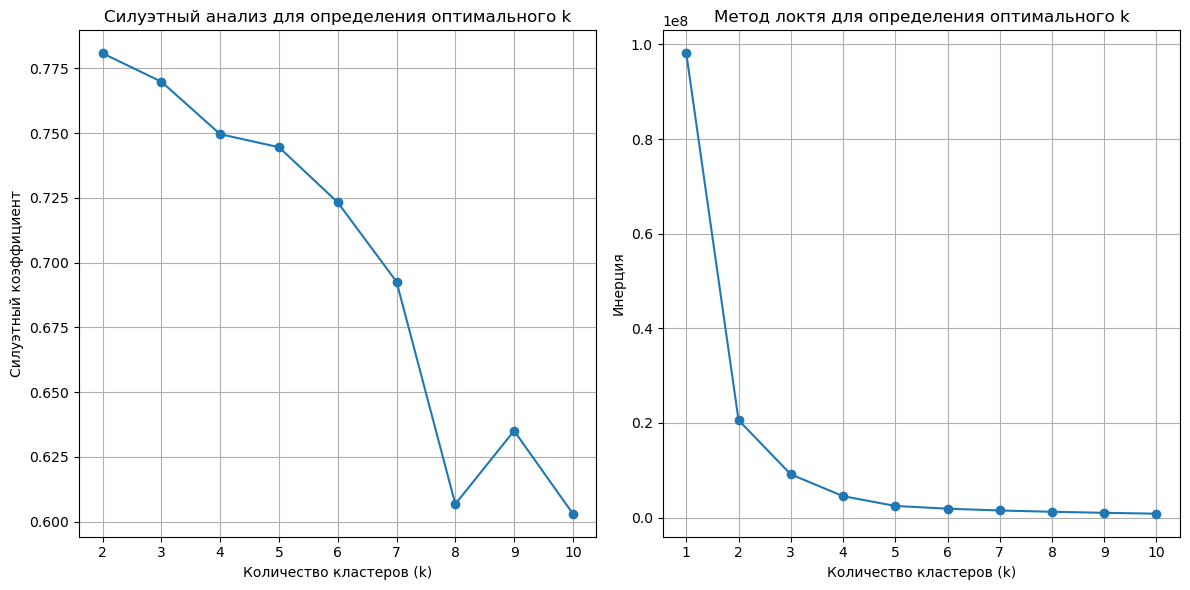

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.measure import label, regionprops
from sklearn.metrics import silhouette_score

num_images = 3  
image_format = ".png"
max_clusters = 10  
def calculate_silhouette_score(image, n_clusters, random_state=42):
    pixels = image.reshape((-1, 1))
    pixels = np.float32(pixels)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(pixels)
    if len(set(cluster_labels)) < 2:
        return -1  
    silhouette_avg = silhouette_score(pixels, cluster_labels)
    return silhouette_avg
def calculate_inertia(image, n_clusters, random_state=42):
    pixels = image.reshape((-1, 1))
    pixels = np.float32(pixels)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    kmeans.fit(pixels)
    return kmeans.inertia_
image_path = f'clean_image_0{image_format}'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if original_image is None:
    print(f"Ошибка при загрузке изображения из {image_path}")
    exit()
silhouette_scores = []
for n_clusters in range(2, max_clusters + 1):  
    silhouette_avg = calculate_silhouette_score(original_image, n_clusters)
    silhouette_scores.append(silhouette_avg)
if silhouette_scores:
    optimal_k_silhouette = np.argmax(silhouette_scores) + 2 
    print(f"Оптимальное количество кластеров согласно силуэтному анализу: {optimal_k_silhouette}")
else:
    optimal_k_silhouette = None
    print("Не удалось вычислить силуэтный коэффициент ни для какого количества кластеров.")
inertia_values = []
for n_clusters in range(1, max_clusters + 1):
    inertia = calculate_inertia(original_image, n_clusters)
    inertia_values.append(inertia)
plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)  
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Силуэтный анализ для определения оптимального k') 
plt.xlabel('Количество кластеров (k)') 
plt.ylabel('Силуэтный коэффициент')
plt.xticks(range(2, max_clusters + 1))
plt.grid(True)
plt.subplot(1, 2, 2) 
plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
plt.title('Метод локтя для определения оптимального k') 
plt.xlabel('Количество кластеров (k)') 
plt.ylabel('Инерция')  
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.tight_layout()  
plt.show()

# 5.2. На выбор, реализация алгоритма сегментации при помощи выбранного алгоритма кластеризации данных: 
 
 https://scikit-learn.ru/stable/modules/clustering.html
 
 5.2.1 Если в кодировке пикселя не использовали его положение, выделите связные регионы.
 
 # 5.3. На выбор, рассчитайте Качество проведенной сегментации на основе характеристик качества кластеризации: 
 
 https://scikit-learn.ru/stable/modules/clustering.html#clustering-evaluation 
 
# 5.4. Визуализируйте результат сегментации
 
# 5.5 Рассчитайте характеристики(описание формы) объектов.
 


Image 1: Silhouette Score = 0.7811, Execution Time = 0.0443 seconds


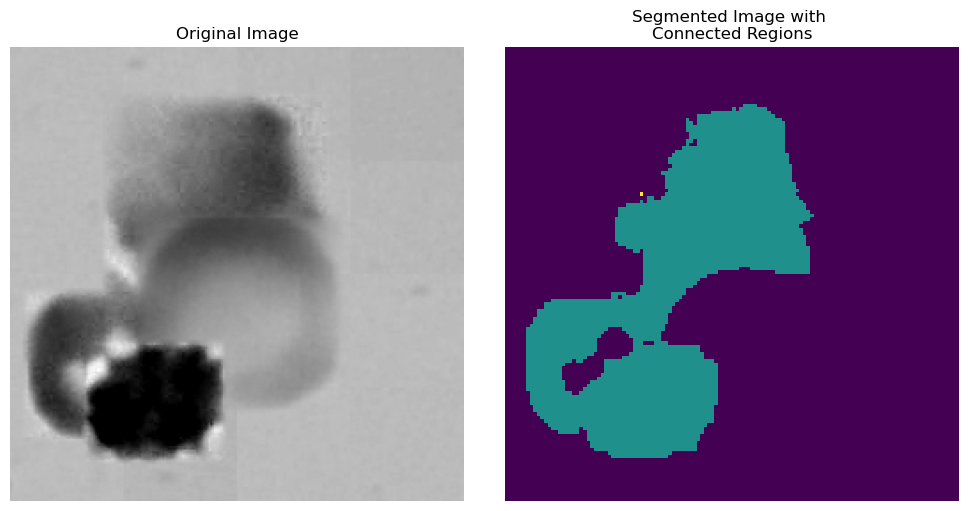

Image 2: Silhouette Score = 0.8876, Execution Time = 0.0410 seconds


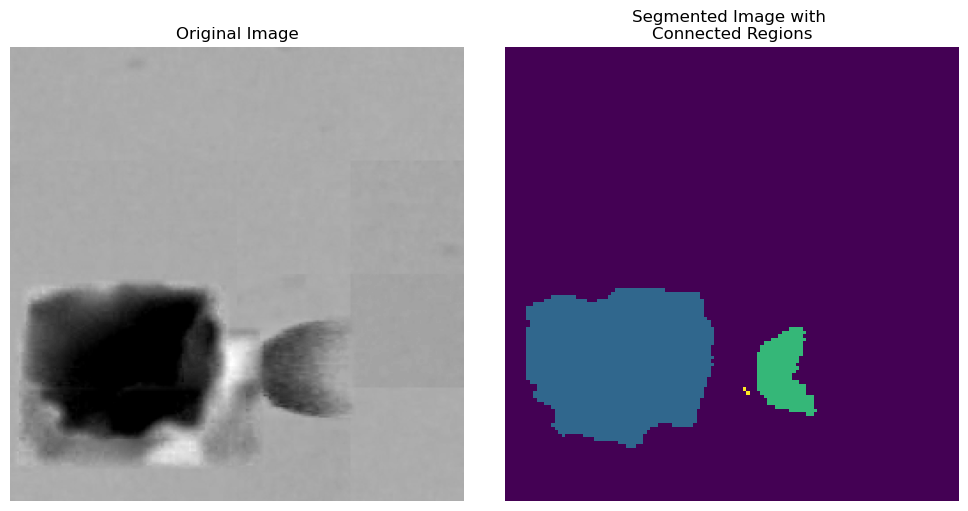

Image 3: Silhouette Score = 0.8486, Execution Time = 0.0439 seconds


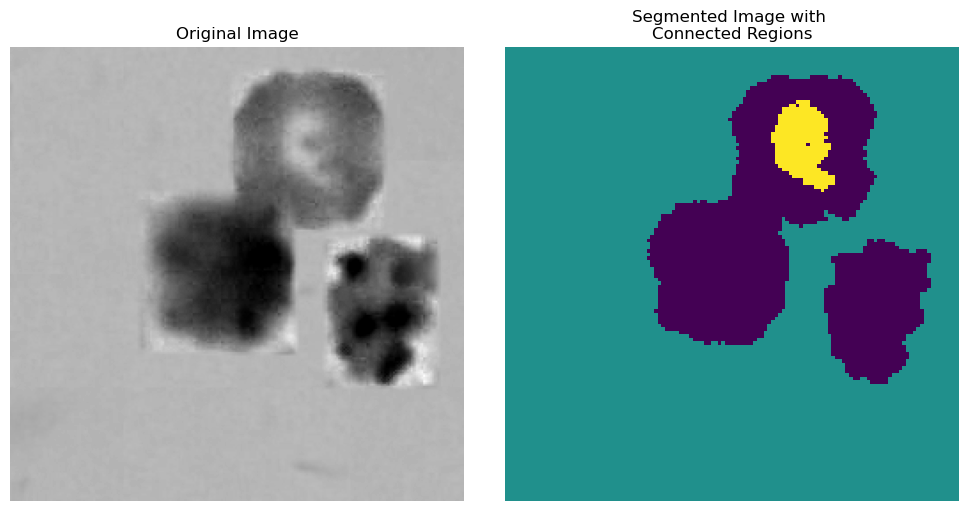


Average Silhouette Score: 0.8391
Average Execution Time: 0.0431 seconds

Object Characteristics:
   image_number   area   perimeter  centroid_row  centroid_col
0             1   3742  465.575685     67.710048     46.774719
1             1      1    0.000000     41.000000     38.000000
2             2   1914  181.882251     88.182863     31.965517
3             2    268   76.769553     91.369403     78.089552
4             2      2    0.000000     96.500000     67.500000
5             3  12714  925.374675     66.916077     58.756017
6             3    303   86.911688     26.953795     83.448845


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.measure import label, regionprops
from sklearn.metrics import silhouette_score
import time
import pandas as pd  

num_images = 3  
image_format = ".png"
n_clusters = 2  
random_state = 42  
resize_factor = 0.5  
silhouette_scores = []
execution_times = []
def segment_and_label(image, n_clusters, random_state):
    pixels = image.reshape((-1, 1))
    pixels = np.float32(pixels)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    segmented_image = labels.reshape(image.shape)
    labeled_image = label(segmented_image)
    return labeled_image, pixels, labels
all_regions_data = []  
for i in range(num_images):
    image_path = f'clean_image_{i}{image_format}'
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        print(f"Error loading image from {image_path}")
        continue
    if resize_factor != 1.0:
        resized_image = cv2.resize(original_image, None, fx=resize_factor, fy=resize_factor,
                                     interpolation=cv2.INTER_AREA)
    else:
        resized_image = original_image
    start_time = time.time()
    labeled_image, pixels, labels = segment_and_label(resized_image, n_clusters, random_state)
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time)
    silhouette_avg = silhouette_score(pixels, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Image {i + 1}: Silhouette Score = {silhouette_avg:.4f}, Execution Time = {execution_time:.4f} seconds")
    regions = regionprops(labeled_image)
    image_regions_data = []
    for region in regions:
        image_regions_data.append({
            'image_number': i + 1, 
            'area': region.area,  
            'perimeter': region.perimeter,  
            'centroid_row': region.centroid[0],  
            'centroid_col': region.centroid[1]  
        })
    all_regions_data.extend(image_regions_data) 
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(f'clean_image_{i}{image_format}', cv2.IMREAD_GRAYSCALE), cmap='gray')  
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(labeled_image, cmap='viridis')
    plt.title("Segmented Image with \nConnected Regions")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
print(f"\nAverage Silhouette Score: {np.mean(silhouette_scores):.4f}")
print(f"Average Execution Time: {np.mean(execution_times):.4f} seconds")
regions_df = pd.DataFrame(all_regions_data)
print("\nObject Characteristics:")
print(regions_df)